In [1]:
from baseline import IGCNet
from model import QGNN

In [2]:
import torch 
import pennylane as qml


train_size = 200
test_size = 100
epochs = 100
batch_size = 32
hidden_channels = 64
graphlet_size = 6
num_ent_layers = 2
num_gnn_layers = 2
seed = 1712
lr = 0.001
step_size = 10
gamma = 0.3
num_nodes = 10
power = 1
noise = 10
pre_train_epoch = 0

node_qubit = graphlet_size
edge_qubit = node_qubit - 1
n_qubits = node_qubit + edge_qubit


step_plot = epochs // 10 if epochs > 10 else 1
device = torch.device("cpu") 
q_dev = qml.device("default.qubit", wires=n_qubits + 1) # number of ancilla qubits


w_shapes_dict = {
    'spreadlayer': (0, n_qubits, 1),
    # OLD
    # 'strong': (2, args.num_ent_layers, 3, 3), # 3
    # 'inits': (1, 4),
    # 'update': (args.graphlet_size, args.num_ent_layers, 3, 3), # (1, args.num_ent_layers, 2, 3)
    # NEW
    'inits': (1, 2), 
    'strong': (1, num_ent_layers, 2, 3), 
    'update': (graphlet_size, num_ent_layers, 3, 3),
    # 'update': (1, args.num_ent_layers, 3, 3), # (1, args.num_ent_layers, 2, 3)
    'twodesign': (0, num_ent_layers, 1, 2)
}

In [3]:
from torch_geometric.loader import DataLoader
from data import d2dGraphDataset
# Load dataset
var_noise = 1/10**(noise/10)  # Convert dB to linear scale
train_dataset = d2dGraphDataset(num_samples=train_size, num_D2D=num_nodes, p_max=power, n0=var_noise, seed=seed)
test_dataset = d2dGraphDataset(num_samples=test_size, num_D2D=num_nodes, p_max=power, n0=var_noise, seed=seed)

node_input_dim = train_dataset[0].x.shape[1] # [direct, weight]
edge_input_dim = train_dataset[0].edge_attr.shape[1] # [inteference]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Generate Data ... (seed = 1712)
Generate Data ... (seed = 1712)


In [4]:
import numpy
data = numpy.load("../../results/d2d/d2d_train/data_20250715-160000_qgnn_6_100_0.0001_D2D.npz")
# data = numpy.load("../../results/d2d/d2d_train/data_20250714-161928_qgnn_6_100_0.001_D2D.npz")
pre_train_epoch = data['epoch'].shape[0]
training_sinr = data['train_sinr'].tolist()
testing_sinr = data['test_sinr'].tolist()

model_quantum = QGNN(
        q_dev=q_dev,
        w_shapes=w_shapes_dict,
        hidden_dim=hidden_channels,
        node_input_dim=node_input_dim,
        edge_input_dim=edge_input_dim,
        graphlet_size=node_qubit,
        hop_neighbor=num_gnn_layers,
    )

pre_trained_path = "../../results/d2d/model/model_20250714-161928_qgnn_6_100_0.001_D2D.pt"
checkpoint = torch.load(pre_trained_path, map_location='cpu')
model_quantum.load_state_dict(checkpoint['model_state_dict'])



Hidden dim: 64


<All keys matched successfully>

In [5]:
epochs = pre_train_epoch + 100
lr = 0.0005
step_size = 10
gamma = 0.005

from baseline import IGCNet
import torch
from torch import nn, optim


training_sinr_gnn = []
testing_sinr_gnn = []
base_model = IGCNet(
    node_input_dim=node_input_dim,
    edge_input_dim=edge_input_dim,
    hidden_channels=hidden_channels,
    num_layers=1
)

base_optimizer = optim.Adam(base_model.parameters(), lr=lr)
base_scheduler = torch.optim.lr_scheduler.StepLR(base_optimizer, step_size=step_size, gamma=0.5)

In [6]:
from utils import train, test
for epoch in range(epochs):
    _, train_gnn = train(base_model, train_loader, base_optimizer, var_noise, power)
    test_gnn = test(base_model, test_loader, var_noise, power)
    training_sinr_gnn.append(train_gnn)
    testing_sinr_gnn.append(test_gnn)
    base_scheduler.step()
    if epoch % step_plot == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Training SINR: {training_sinr_gnn[-1]:.4f}, Testing SINR: {testing_sinr_gnn[-1]:.4f}")


Epoch 1/200, Training SINR: 0.7616, Testing SINR: 0.7214
Epoch 11/200, Training SINR: 1.6389, Testing SINR: 1.4097
Epoch 21/200, Training SINR: 2.0360, Testing SINR: 1.8661
Epoch 31/200, Training SINR: 2.2636, Testing SINR: 2.0943
Epoch 41/200, Training SINR: 2.3448, Testing SINR: 2.2226
Epoch 51/200, Training SINR: 2.4225, Testing SINR: 2.3372
Epoch 61/200, Training SINR: 2.4692, Testing SINR: 2.3605
Epoch 71/200, Training SINR: 2.4962, Testing SINR: 2.3766
Epoch 81/200, Training SINR: 2.5155, Testing SINR: 2.3927
Epoch 91/200, Training SINR: 2.5185, Testing SINR: 2.4044
Epoch 101/200, Training SINR: 2.5168, Testing SINR: 2.3976
Epoch 111/200, Training SINR: 2.5241, Testing SINR: 2.4076
Epoch 121/200, Training SINR: 2.5057, Testing SINR: 2.4076
Epoch 131/200, Training SINR: 2.5116, Testing SINR: 2.4218
Epoch 141/200, Training SINR: 2.5131, Testing SINR: 2.4105
Epoch 151/200, Training SINR: 2.5162, Testing SINR: 2.4144
Epoch 161/200, Training SINR: 2.5121, Testing SINR: 2.4156
Epoch 17

In [7]:
import numpy
total_wmmse = 0
# total_fp = 0
num_batch = 0
for data in train_loader:
    total_wmmse += numpy.sum(data.y[:,0].detach().numpy())
    # total_fp += numpy.sum(data.y[:,1].detach().numpy())
    num_batch += data.num_graphs
train_wmmse = total_wmmse/num_batch
# train_fp = total_fp/num_batch

total_wmmse = 0
# total_fp = 0
num_batch = 0
for data in test_loader:
    total_wmmse += numpy.sum(data.y[:,0].detach().numpy())
    # total_fp += numpy.sum(data.y[:,1].detach().numpy())
    num_batch += data.num_graphs
test_wmmse = total_wmmse/num_batch

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def moving_avg(y, k=5):
    """Simple centred moving average of width k (k should be odd)."""
    pad = k // 2
    y_padded = np.pad(y, (pad, pad), mode="edge")
    return np.convolve(y_padded, np.ones(k)/k, mode="valid")
k = 11
smooth_train = moving_avg(training_sinr, k=k)   # k=7‑point window
smooth_test  = moving_avg(testing_sinr,  k=k)

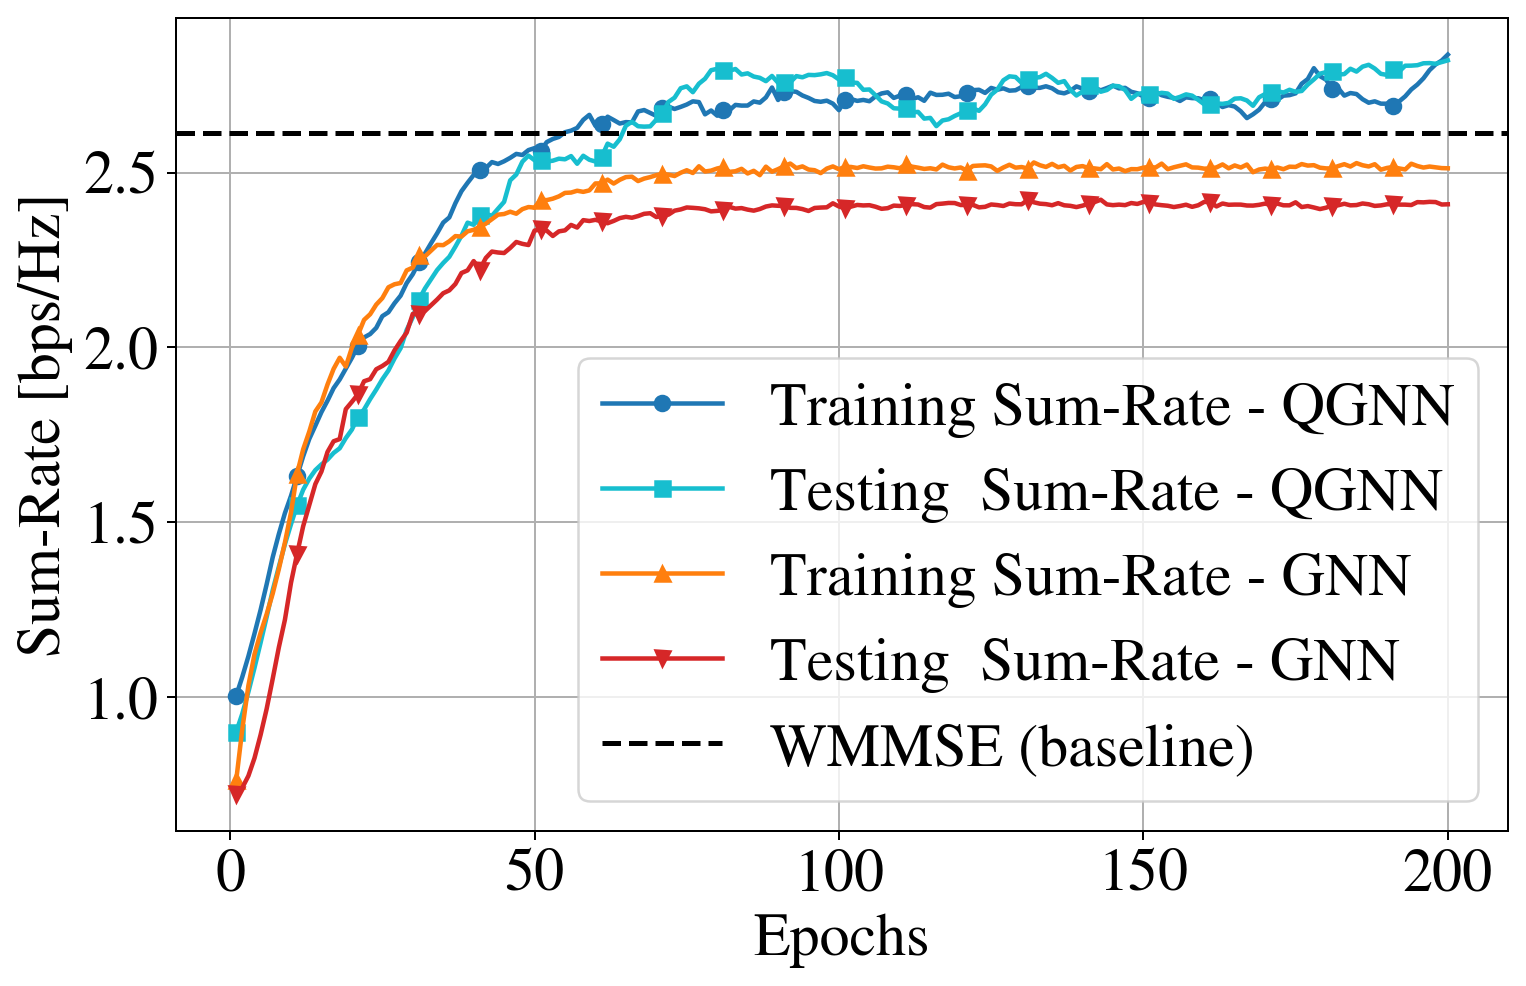

In [12]:
import matplotlib.pyplot as plt

plt.rc("text", usetex=False)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(figsize=(9, 6), dpi=180)

# QGNN
plt.plot(range(1, epochs+1), smooth_train*1.05,
# plt.plot(range(1, epochs + 1), training_sinr,
        label=f'Training Sum-Rate - QGNN', markevery=step_plot,
        marker='o', linewidth=1.8, color='tab:blue')

plt.plot(range(1, epochs+1), smooth_test,
# plt.plot(range(1, epochs + 1), testing_sinr,
        label=f'Testing  Sum-Rate - QGNN', markevery=step_plot,
        marker='s', linewidth=1.8, color='tab:cyan')


plt.plot(range(1, epochs + 1), numpy.array(training_sinr_gnn),
        label=f'Training Sum-Rate - GNN', markevery=step_plot,
        marker='^', linewidth=1.8, color='tab:orange')

plt.plot(range(1, epochs + 1), numpy.array(testing_sinr_gnn),
        label=f'Testing  Sum-Rate - GNN', markevery=step_plot,
        marker='v', linewidth=1.8, color='tab:red')

# WMMSE baseline
plt.axhline(y=test_wmmse, color='k', linestyle='--', linewidth=2,
            label='WMMSE (baseline)')

# plt.title('Unsupervised Setting')
plt.xlabel('Epochs')
plt.ylabel('Sum-Rate [bps/Hz]')
# plt.xticks(range(1,total_epoch+1))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("../../results/D2D_Res.pdf", format="pdf", bbox_inches="tight")

# Eval

In [18]:
eval_size = 100
eval_seed = 1309
all_scenarios = [
    (10, 1),
    (20, 1),
    (30, 1),
    (40, 1),
    (10, 2),
    (20, 2),
    (30, 2),
    (40, 2),
]

In [19]:
for num_nodes, power in all_scenarios:
    # Create new evaluation dataset and loader
    eval_dataset = d2dGraphDataset(
        num_samples=eval_size,  # e.g., 500 or 1000
        num_D2D=num_nodes,
        p_max=power,
        n0=var_noise,
        seed=eval_seed  # optional, for reproducibility
    )
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
    
    total_wmmse = 0
    # total_fp = 0
    num_batch = 0
    for data in eval_loader:
        total_wmmse += numpy.sum(data.y[:,0].detach().numpy())
        # total_fp += numpy.sum(data.y[:,1].detach().numpy())
        num_batch += data.num_graphs
    eval_wmmse = total_wmmse/num_batch


    # Evaluate
    eval_sinr = test(base_model, eval_loader, var_noise, power)
    eval_sinr_quantum = test(model_quantum, eval_loader, var_noise, power)
    print(f"{num_nodes} D2D pairs, power {power} W")
    print(f"GNN Sum-rate: {eval_sinr:.4f} - {eval_sinr/eval_sinr*100:.2f}")
    print(f"SQM-GNN Sum-rate: {eval_sinr_quantum:.4f} - {eval_sinr_quantum/eval_sinr*100:.2f}")
    print(f"WMMSE Sum-rate: {eval_wmmse:.4f} - {eval_wmmse/eval_sinr*100:.2f}")


Generate Data ... (seed = 1309)
10 D2D pairs, power 1 W
GNN Sum-rate: 2.5169 - 100.00
SQM-GNN Sum-rate: 2.8229 - 112.16
WMMSE Sum-rate: 2.4749 - 98.33
Generate Data ... (seed = 1309)
20 D2D pairs, power 1 W
GNN Sum-rate: 1.6986 - 100.00
SQM-GNN Sum-rate: 1.9831 - 116.75
WMMSE Sum-rate: 2.9138 - 171.54
Generate Data ... (seed = 1309)
30 D2D pairs, power 1 W
GNN Sum-rate: 1.5012 - 100.00
SQM-GNN Sum-rate: 1.5426 - 102.76
WMMSE Sum-rate: 3.2397 - 215.80
Generate Data ... (seed = 1309)
40 D2D pairs, power 1 W
GNN Sum-rate: 1.4378 - 100.00
SQM-GNN Sum-rate: 1.3386 - 93.10
WMMSE Sum-rate: 3.4520 - 240.10
Generate Data ... (seed = 1309)
10 D2D pairs, power 2 W
GNN Sum-rate: 0.5510 - 100.00
SQM-GNN Sum-rate: 4.1277 - 749.09
WMMSE Sum-rate: 3.3752 - 612.51
Generate Data ... (seed = 1309)
20 D2D pairs, power 2 W
GNN Sum-rate: 0.4066 - 100.00
SQM-GNN Sum-rate: 2.1762 - 535.19
WMMSE Sum-rate: 3.6869 - 906.71
Generate Data ... (seed = 1309)
30 D2D pairs, power 2 W
GNN Sum-rate: 0.4426 - 100.00
SQM-

# Parameters

In [ ]:
from baseline import IGCNet
from model import QGNN


# w_shapes_dict = {
#     'spreadlayer': (0, n_qubits, 1),
#     # OLD
#     # 'strong': (2, args.num_ent_layers, 3, 3), # 3
#     # 'inits': (1, 4),
#     # 'update': (args.graphlet_size, args.num_ent_layers, 3, 3), # (1, args.num_ent_layers, 2, 3)
#     # NEW
#     'inits': (1, 2), 
#     'strong': (1, num_ent_layers, 2, 3), 
#     'update': (graphlet_size, num_ent_layers, 3, 3),
#     # 'update': (1, args.num_ent_layers, 3, 3), # (1, args.num_ent_layers, 2, 3)
#     'twodesign': (0, num_ent_layers, 1, 2)
# }

# model_quantum = QGNN(
#         q_dev=q_dev,
#         w_shapes=w_shapes_dict,
#         hidden_dim=hidden_channels,
#         node_input_dim=node_input_dim,
#         edge_input_dim=edge_input_dim,
#         graphlet_size=node_qubit,
#         hop_neighbor=num_gnn_layers,
#     )
# model_classical = IGCNet(
#     node_input_dim=node_input_dim,
#     edge_input_dim=edge_input_dim,
#     hidden_channels=hidden_channels,
#     num_layers=num_gnn_layers
# )      

In [ ]:
def inspect_params(model, quantum_keywords=("qconv", "quantum", "q_layer")):
    classical, quantum = [], []
    classical_keywords = (
        "input_node", 
        'input_edge', 
        "final_layer", 
        "norms", 
        # "upds"
    )
    for name, param in model.named_parameters():
        if any(key in name for key in quantum_keywords):
            quantum.append((name, param.numel()))
        else:
            if any(key in name for key in classical_keywords):
                classical.append((name, param.numel()))
    return classical, quantum


In [ ]:
# Classical model
params_igc = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
print(f"IGCNet total params: {params_igc}")

# Quantum model
cl_p, q_p = inspect_params(model_quantum)

print(f"QGNN classical params: {sum(p[1] for p in cl_p)}")
print(f"QGNN quantum params:   {sum(p[1] for p in q_p)}")
print(f"QGNN total:            {sum(p[1] for p in cl_p + q_p)}")
